In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [12]:
class Data(object):

    def __init__(self, path):
        self.__dataset = self._build_dataset(path)

    @staticmethod
    def _build_dataset(path):
        structure = [('x', float),
                     ('y', float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv) if i != 0)
            data = np.fromiter(data_gen, structure)

        return data

    def get_xy(self):
        return self.__dataset['x'], self.__dataset['y']
        
    def split(self, percentage):  # 0.8
        X = self.__dataset['x']
        y = self.__dataset['y']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(X.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
        # [9,0]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test

dataset_x shape: (499,)
dataset_y shape: (499,)


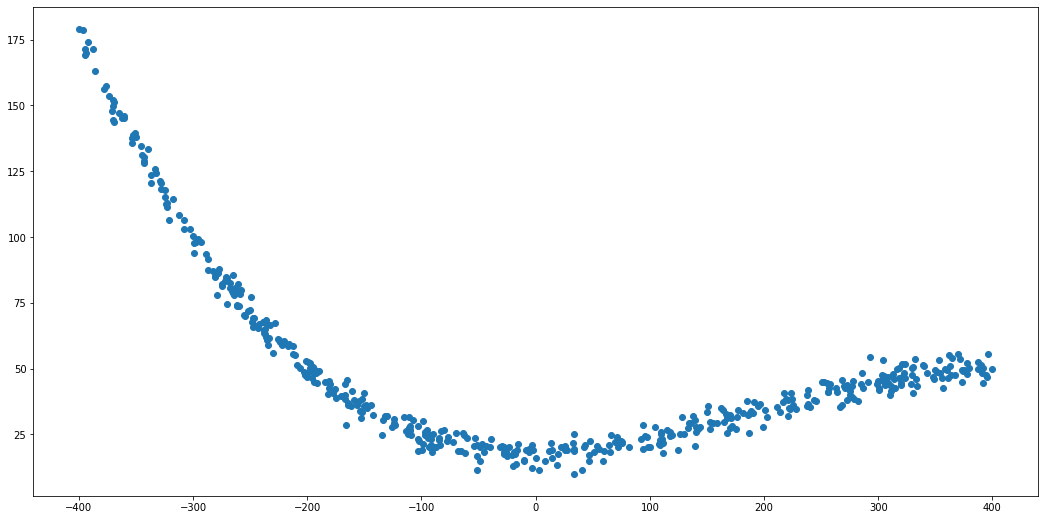

In [13]:
dataset = Data(os.getcwd() + os.sep + 'clase_8_dataset.csv')
dataset_x, dataset_y = dataset.get_xy()
print(f'dataset_x shape: {dataset_x.shape}')
print(f'dataset_y shape: {dataset_y.shape}')
plt.scatter(dataset_x, dataset_y)

X_train shape: (399,)
X_test shape: (100,)
y_train shape: (399,)
y_train shape: (100,)


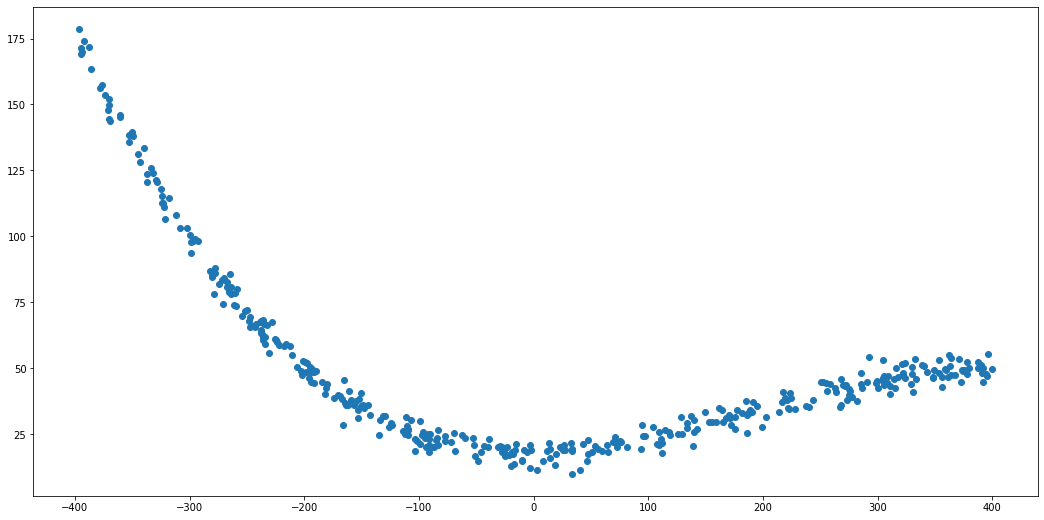

In [14]:
X_train, X_test, y_train, y_test = dataset.split(0.8)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_train shape: {y_test.shape}')
plt.scatter(X_train, y_train)

In [15]:
class BaseModel(object):

    def __init__(self):
        self.__model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented


class PolyRegression(BaseModel):

    def __init__(self, order=1):
        self.__model = None
        self.__order = order

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        Xs = []
        for i in range(self.__order):
            Xs.append(np.power(X, self.__order - i))
            
        Xs.append(np.ones(len(X)))
        X = np.vstack(Xs).T
        if len(X.shape) == 1:
            W = X.T.dot(y) / X.T.dot(X)
        else:
            W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.__model = W

    def predict(self, X):
        W = self.__model
        prediction = 0
        for i in range(len(W)):
            prediction += W[i] * np.power(X, (len(W) - 1 - i))
        return prediction


In [16]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

In [17]:
def k_folds(X_train, y_train, regression, k=10):
    error = MSE()

    chunk_size = int(len(X_train) / 5)
    mse_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + \
            chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        regression.fit(new_X_train, new_y_train.reshape(-1, 1))
        prediction = regression.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))

    mean_MSE = np.mean(mse_list)

    return mean_MSE


Mean MSE para orden 1: 788.6839453450366
Mean MSE para orden 2: 97.66078420996206
Mean MSE para orden 3: 8.879687140862373
Mean MSE para orden 4: 8.888175671618646


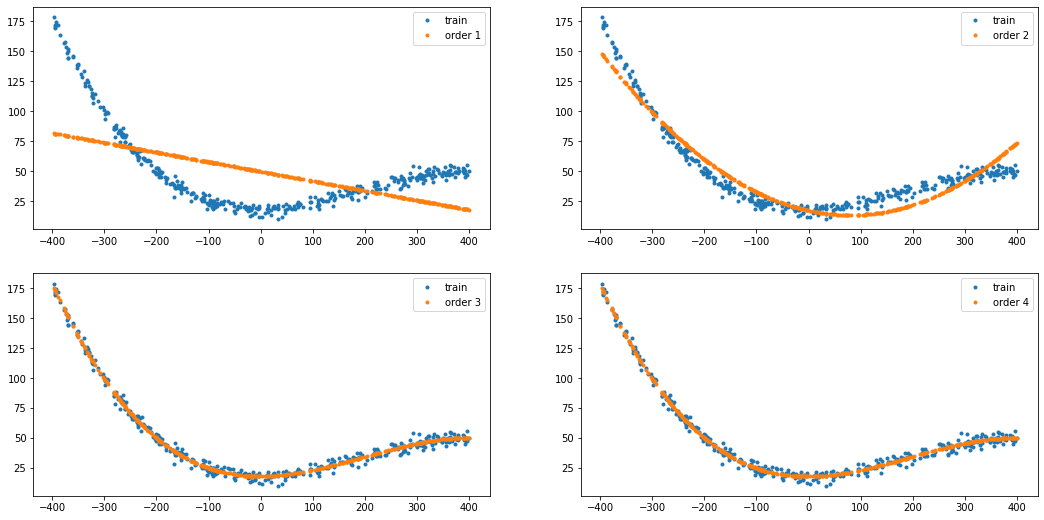

In [18]:
# PLOTS
plt.rcParams['figure.figsize'] = [18, 9]
fig, axs = plt.subplots(2, 2)
ax = axs.flatten()

for i in range(4):
    regression = PolyRegression(i + 1)
    regression.fit(X_train, y_train)
    y = regression.predict(X_train)

    mean_MSE = k_folds(X_train, y_train, regression, 5)
    print(f'Mean MSE para orden {i + 1}: {mean_MSE}')

    # original
    ax[i].plot(X_train, y_train, '.')

    # linear
    ax[i].plot(X_train, y, '.')
    
    ax[i].legend(['train', f'order {i + 1}'])

plt.show()


## Modelo seleccionado

De acuerdo a los resultados de la media de **MSE**, seleccionamos el polinomio de orden 3. Este es el que da el mínimo **MSE**, en promedio

## Optimización _Mini-Batch Gradient Descent_

In [19]:
class MiniBach_GradientDecent(BaseModel):
    def z_score_dataset(self, x):
        mean = np.mean(x, axis=0)
        std = np.std(x, axis=0)
        return (x - mean) / std

    def __init__(self):
        super().__init__()

    def fit(self, X_train, y_train, X_valid, y_valid, lr=0.00001, amt_epochs=1):
        """
        shapes:
            X_t = nxm
            y_t = nx1
            W = mx1
        """
        b = 32
        n = X_train.shape[0]
        m = X_train.shape[1]

        error_MSE = MSE()
        mse_list = []

        X_train[:, :-1] = self.z_score_dataset(X_train[:, :-1])
        X_valid = self.z_score_dataset(X_valid)

        # initialize random weights
        W = np.random.randn(m).reshape(m, 1)

        for i in range(amt_epochs):
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            y_train = y_train[idx]

            batch_size = int(len(X_train) / b)
            for i in range(0, len(X_train), batch_size):
                end = i + batch_size if i + \
                    batch_size <= len(X_train) else len(X_train)
                batch_X = X_train[i: end]
                batch_y = y_train[i: end]

                prediction = np.matmul(batch_X, W)  # nx1
                error = batch_y - prediction  # nx1

                grad_sum = np.sum(error * batch_X, axis=0)
                grad_mul = -2/n * grad_sum  # 1xm
                gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1
                W = W - (lr * gradient)

            self.__model = W
            prediction = self.predict(X_valid)
            mse_list.append(error_MSE(y_valid, prediction))
        return mse_list, self.__model

    def predict(self, X):
        X = self.z_score_dataset(X)
        W = self.__model
        prediction = 0
        for i in range(len(W)):
            prediction += W[i] * np.power(X, (len(W) - 1 - i))
        return prediction


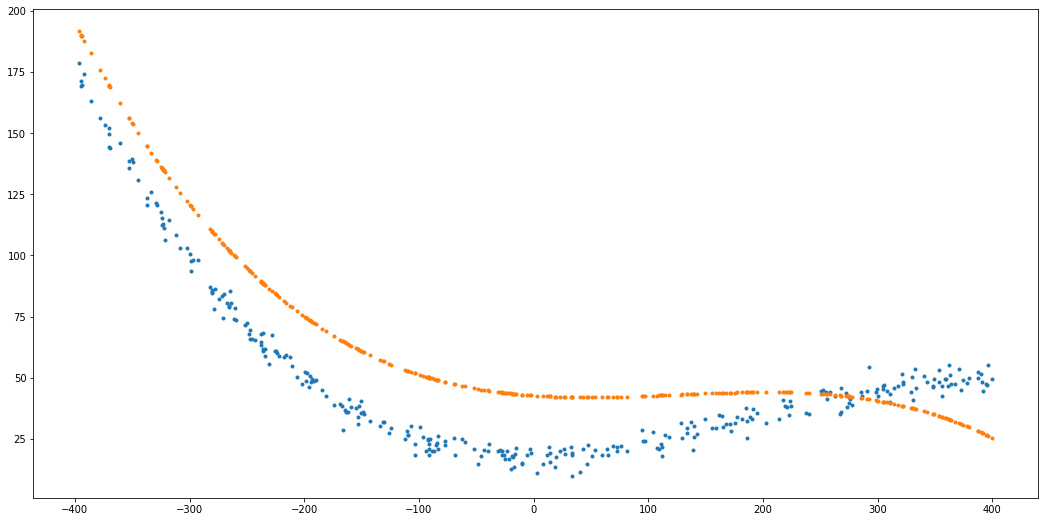

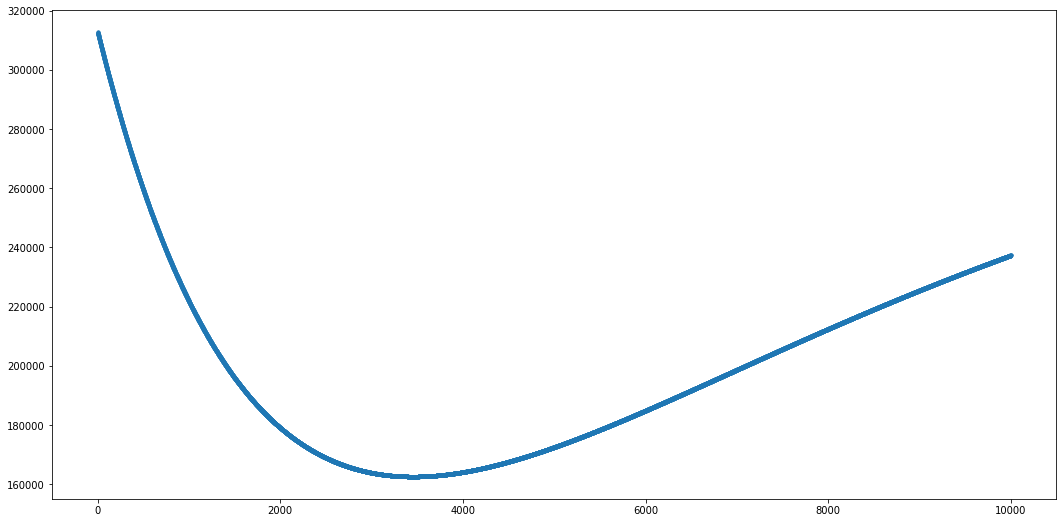

In [20]:
regression = MiniBach_GradientDecent()

chunk_size = int(len(X_train) / 5)
new_X_train = X_train[: 4 * chunk_size]
new_y_train = y_train[: 4 * chunk_size]
new_X_valid = X_train[4 * chunk_size: len(X_train)]
new_y_valid = y_train[4 * chunk_size: len(y_train)]

X_expanded_train = np.vstack(
    (new_X_train**3, new_X_train**2, new_X_train, np.ones(len(new_X_train)))).T
mse_list, W = regression.fit(X_expanded_train, new_y_train.reshape(-1, 1),
                             new_X_valid, new_y_valid.reshape(-1, 1), lr=0.0001, amt_epochs=10000)
y = regression.predict(new_X_train)


plt.figure()
plt.subplot(1, 1, 1)
plt.plot(new_X_train, new_y_train, '.')
plt.plot(new_X_train, y, '.')

plt.figure()
plt.subplot(1, 1, 1)
plt.plot(mse_list, '.')
